<a href="https://colab.research.google.com/github/rykah14/DrugReviewDataset/blob/main/_DrugReviewDataset_multiclass_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 12.3MB/s 
     |████████████████████████████████| 890kB 57.6MB/s 
     |████████████████████████████████| 2.9MB 59.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e874972d150a854919be5b5175d8a6fe3e2f757cc3e97bade97b4c3d2ad88d4a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=ae5458b315c828ec027a64b6bc463dc36290686b595a47e64554738c0a9f9456
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip

--2021-01-07 10:55:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  13.5MB/s    in 3.0s    

2021-01-07 10:55:51 (13.5 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]



In [6]:
!unzip drugsCom_raw.zip

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [7]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_table("drugsComTest_raw.tsv", delimiter='\t', header=None, names=['drugName','condition','review',	'rating'	,'date','usefulCount'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 53,767



,drugName,condition,review,rating,date,usefulCount
82224.0,Liraglutide,"Diabetes, Type 2","""I have been using Victoza for nearly 2 years ...",9.0,"March 13, 2016",23
210596.0,Mirtazapine,Depression,"""Worst psychiatric drug I&#039;ve ever taken. ...",1.0,"August 26, 2017",11
122781.0,Linaclotide,"Constipation, Chronic","""I&#039;ve been chronically constipated for as...",10.0,"November 29, 2014",57
36009.0,Buprenorphine / naloxone,Opiate Dependence,"""Well I have seen my husband going down and do...",9.0,"February 6, 2011",10
215282.0,Lubiprostone,"Constipation, Chronic","""Have taken it for one day and I feel better a...",9.0,"January 13, 2009",35
22205.0,Baclofen,Muscle Spasm,"""I was prescribed Baclofen to help spasms and ...",9.0,"November 14, 2015",88
124679.0,Irbesartan,High Blood Pressure,"""I have been on Avapro about a week and do not...",7.0,"June 10, 2010",72
183156.0,Cymbalta,Depression,"""I have been taking different medicines for de...",1.0,"October 21, 2013",24
229709.0,Lurasidone,Schizophrenia,"""Excellent medicine in my experience.\r\n\r\nI...",10.0,"January 12, 2013",79
171220.0,Levitra,Erectile Dysfunction,"""Have used Viagra 100MG split into halves or t...",9.0,"February 3, 2014",114


In [9]:
!sed -e 's/"/'\''/g' ./drugsComTest_raw.tsv > ./drugsComTest_raw_re.tsv

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_table('./drugsComTest_raw_re.tsv', header=None, sep='\t', names=['drugName','condition','review',	'rating'	,'date','usefulCount'])

# データの抽出
df = df.loc[df['condition'].isin(['Depression','Pain','Birth Control']), ['condition', 'review']]
#multi class 分類をする
#新たにBirth Controlを追加する
df=df.replace('Depression', 0)
df=df.replace('Pain', 1)
df=df.replace('Birth Control', 2)
#のちのことを考慮してint型の数値にreplace
print(df[:10])


        condition                                             review
163740          0  '''I&#039;ve tried a few antidepressants over ...
97768           2  '''I have been on this birth control for one c...
215892          2  '''I&#039;ve had the copper coil for about 3 m...
71428           2  '''I was on this pill for almost two years. It...
79865           2  '''I absolutely love this product and recommen...
178004          1  '''Been on 30mg Cymbalta for 2 weeks. Started ...
60341           2  '''I was on this for 5 years (and birth contro...
141462          0  '''I am a 22 year old female college student. ...
101371          2  '''I&#039;m absolutely DONE taking this horrib...
17957           2  '''I started on the oral contraceptive pill bu...


In [18]:
df.loc[df.condition == 2].sample(5)[['condition','review']]

,condition,review
48374,2,'''I took this for one week. It gave me terrib...
16329,2,"'''Other than mood swings and headaches, this ..."
18221,2,'''I have been using the Nuva-ring for about 5...
81421,2,'''I&#039;ve been on Yaz for just about a mont...
165845,2,'''I was so terrified about the insertion but ...


In [19]:
# Get the lists of sentences and their labels.
conditions = df.condition.values
reviews = df.review.values

In [20]:
print(reviews[1:10])

["'''I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend'''"
 "'''I&#039;ve had the copper coil for about 3 months now. I was really excited at the thought of not taking hormones. I&#039;m good with pain however I nearly fainted with insertion, couldn&#039;t belive how painful it was; the d

In [21]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [22]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [23]:
# Print the original sentence.
print(' Original: ', reviews[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(reviews[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[10])))

 Original:  '''About two months ago I had to switch from LoLestrin Fe to microgestin due to my insurance and pharmacy. Since starting microgestin I&#039;ve noticed insane bloating and nausea and weird discharge. While on lolestrin, my periods consisted of spotting and average side effects, nothing too serious, but after one month of micro I got my period and it was heavy and the cramping was so painful I had to leave my class. I&#039;ve also noticed I&#039;ve developed bad depression and my mood swings are very intense. My anxiety is bad and my sex drive is very low if not nonexistent anymore. It helped with my acne but I&#039;m a lot more paranoid about getting pregnant than I was on lolestrin. I&#039;m going to be talking to my doctor about possibly getting the shot.'''
Tokenized:  ["'", "'", "'", 'about', 'two', 'months', 'ago', 'i', 'had', 'to', 'switch', 'from', 'lo', '##les', '##tri', '##n', 'fe', 'to', 'micro', '##ges', '##tin', 'due', 'to', 'my', 'insurance', 'and', 'pharmacy',

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in reviews:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[10])
print('Token IDs:', input_ids[10])

Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


Original:  '''About two months ago I had to switch from LoLestrin Fe to microgestin due to my insurance and pharmacy. Since starting microgestin I&#039;ve noticed insane bloating and nausea and weird discharge. While on lolestrin, my periods consisted of spotting and average side effects, nothing too serious, but after one month of micro I got my period and it was heavy and the cramping was so painful I had to leave my class. I&#039;ve also noticed I&#039;ve developed bad depression and my mood swings are very intense. My anxiety is bad and my sex drive is very low if not nonexistent anymore. It helped with my acne but I&#039;m a lot more paranoid about getting pregnant than I was on lolestrin. I&#039;m going to be talking to my doctor about possibly getting the shot.'''
Token IDs: [101, 1005, 1005, 1005, 2055, 2048, 2706, 3283, 1045, 2018, 2000, 6942, 2013, 8840, 4244, 18886, 2078, 10768, 2000, 12702, 8449, 7629, 2349, 2000, 2026, 5427, 1998, 13882, 1012, 2144, 3225, 12702, 8449, 7629

In [25]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  609


In [26]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


In [27]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [28]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_conditions, validation_conditions = train_test_split(input_ids, conditions, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, conditions,
                                             random_state=2018, test_size=0.1)

In [29]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_conditions = torch.tensor(train_conditions)
validation_conditions = torch.tensor(validation_conditions)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_conditions)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_conditions)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
             
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

In [35]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    418.    Elapsed: 0:00:09.
  Batch    80  of    418.    Elapsed: 0:00:17.
  Batch   120  of    418.    Elapsed: 0:00:26.
  Batch   160  of    418.    Elapsed: 0:00:35.
  Batch   200  of    418.    Elapsed: 0:00:43.
  Batch   240  of    418.    Elapsed: 0:00:52.
  Batch   280  of    418.    Elapsed: 0:01:00.
  Batch   320  of    418.    Elapsed: 0:01:09.
  Batch   360  of    418.    Elapsed: 0:01:17.
  Batch   400  of    418.    Elapsed: 0:01:26.

  Average training loss: 0.24
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    418.    Elapsed: 0:00:09.
  Batch    80  of    418.    Elapsed: 0:00:17.
  Batch   120  of    418.    Elapsed: 0:00:26.
  Batch   160  of    418.    Elapsed: 0:00:34.
  Batch   200  of    418.    Elapsed: 0:00:43.
  Batch   240  of    418.    Elapsed: 0:00:51.
  Batch   280  of    418.    Elap

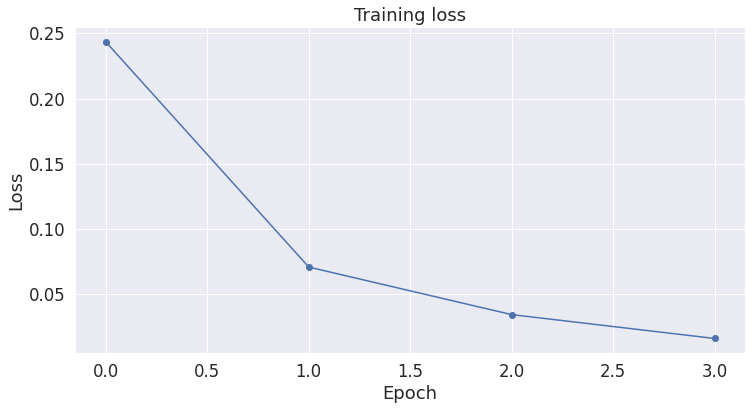

In [38]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()